# pip installs

In [79]:
!pip install datasets


# imports


In [80]:
#title
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt
import re
import string
from matplotlib.patches import Patch
import nltk
from nltk import pos_tag, word_tokenize



# EDA 1

In [3]:
#loading data
dataset = load_dataset("artem9k/ai-text-detection-pile")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['source', 'id', 'text'],
        num_rows: 1392522
    })
})


In [ ]:

data = dataset["train"].to_pandas()
data.head()

,source,id,text
0,human,0,12 Years a Slave: An Analysis of the Film Essa...
1,human,1,20+ Social Media Post Ideas to Radically Simpl...
2,human,2,2022 Russian Invasion of Ukraine in Global Med...
3,human,3,533 U.S. 27 (2001) Kyllo v. United States: The...
4,human,4,A Charles Schwab Corporation Case Essay\n\nCha...


In [ ]:
#null
print(data.isnull().sum())

source    0
id        0
text      0
dtype: int64


source
human    1028146
ai        364376
Name: count, dtype: int64


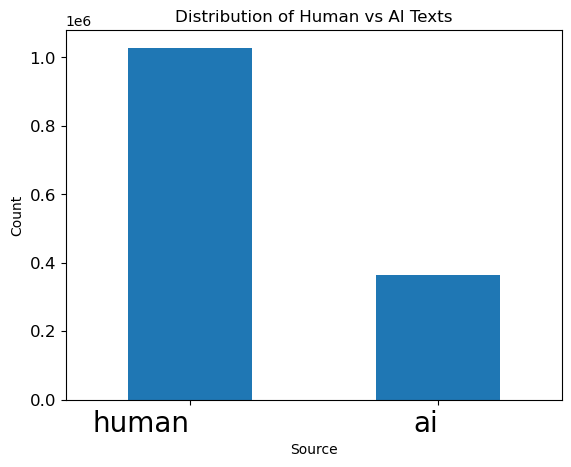

In [6]:
print(data["source"].value_counts())
data["source"].value_counts().plot(kind="bar")
plt.title("Distribution of Human vs AI Texts")
plt.xlabel("Source")
plt.ylabel("Count")
plt.xticks(fontsize=20, rotation=0, ha="right")                # Bigger x-ticks, rotated for readability
plt.yticks(fontsize=12)    
plt.show()

# data engineering 1

In [7]:
#balancing data to 300,000 rows each

human_df = data[data["source"] == "human"].sample(n=500000, random_state=42)
ai_df    = data[data["source"] == "ai"].sample(n=300000, random_state=42)


df = pd.concat([human_df, ai_df]).reset_index(drop=True)

print(df["source"].value_counts())

source
human    500000
ai       300000
Name: count, dtype: int64


# EDA 2

In [8]:
#text length mean 

df["text_length"] = df["text"].str.len()

print("text length by source: ",df.groupby("source")["text_length"].mean())

text length by source:  source
ai       2219.645987
human    2457.011402
Name: text_length, dtype: float64


In [9]:
print("text length by source: ",df.groupby("source")["text_length"].median())

text length by source:  source
ai       1771.0
human     996.0
Name: text_length, dtype: float64


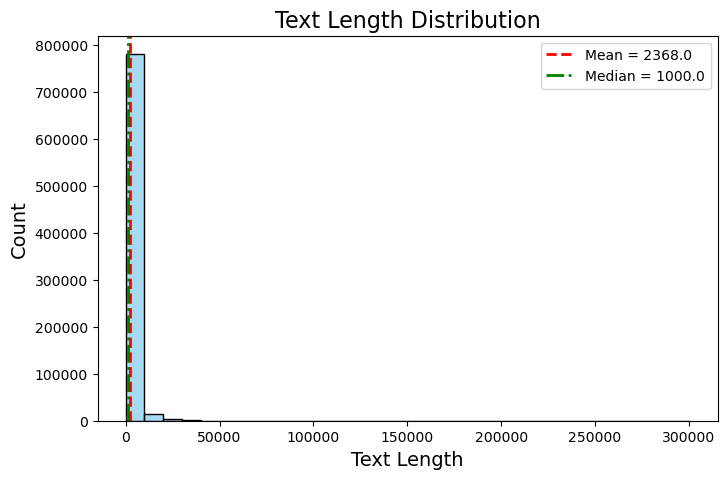

In [10]:


plt.figure(figsize=(8,5))

# Plot a single histogram (no separation by source)
sns.histplot(df["text_length"], bins=30, kde=False, color="skyblue")

# Calculate stats
mean_val = df["text_length"].mean()
median_val = df["text_length"].median()

# Add lines
plt.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_val:.1f}")
plt.axvline(median_val, color="green", linestyle="-.", linewidth=2, label=f"Median = {median_val:.1f}")

# Titles & labels
plt.title("Text Length Distribution", fontsize=16)
plt.xlabel("Text Length", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend()

plt.show()


In [ ]:
# counting sentences

def count_sentences(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    # Split by ., !, ? followed by space or end of string
    sentences = re.split(r'[.!?]+(?:\s|$)', text.strip())
    # Remove empty strings
    sentences = [s for s in sentences if s]
    return len(sentences)

df["sentence_count"] = df["text"].apply(count_sentences)

In [12]:
print(df.groupby("source")["sentence_count"].mean())       # average sentences


source
ai       17.901023
human    24.897236
Name: sentence_count, dtype: float64


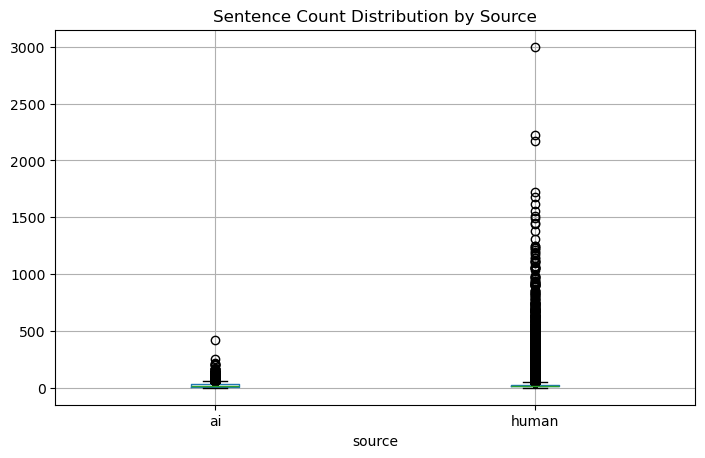

In [13]:
df.boxplot(column="sentence_count", by="source", figsize=(8,5))
plt.title("Sentence Count Distribution by Source")
plt.suptitle("")
plt.show()

In [14]:
def count_words(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    return len(text.split())

def avg_words_per_sentence(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    # Split into sentences
    sentences = re.split(r'[.!?]+(?:\s|$)', text.strip())
    sentences = [s for s in sentences if s.strip()]
    if not sentences:
        return 0
    # Count words in each sentence
    word_counts = [len(s.split()) for s in sentences]
    return sum(word_counts) / len(word_counts)

df["word_count"] = df["text"].apply(count_words)
df["avg_words_per_sentence"] = df["text"].apply(avg_words_per_sentence)


        word_count  avg_words_per_sentence
source                                    
ai      386.738653               23.392167
human   405.118214               17.566498


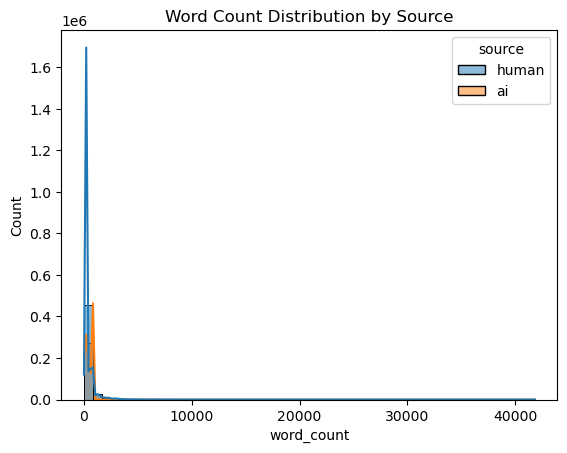

In [15]:
print(df.groupby("source")[["word_count", "avg_words_per_sentence"]].mean())
sns.histplot(data=df, x="word_count", hue="source", kde=True, bins=50)
plt.title("Word Count Distribution by Source")
plt.show()

In [16]:
punctuations = string.punctuation  # !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

# Count occurrences of each punctuation in every text
for p in punctuations:
    df[f"count_{p}"] = df["text"].str.count(re.escape(p))

In [17]:
punct_summary = df.groupby("source")[[col for col in df.columns if col.startswith("count_")]].sum().T
punct_summary.columns = ["AI", "Human"] if "ai" in punct_summary.columns else punct_summary.columns
print(punct_summary)

              AI     Human
count_!    96275    313159
count_"  2049144    866677
count_#    21826     37229
count_$   117155    108328
count_%    47173    114948
count_&    24074    230407
count_'  2262153   3457076
count_(   410936   1313299
count_)   425297   1320245
count_*    19702    475409
count_+    20048     40980
count_,  5546386  10862985
count_-  1117269   2004292
count_.  5896752  13246497
count_/   193551    305179
count_:   449305    809063
count_;    84820    249945
count_<    14818     16461
count_=    36690     73914
count_>    22284     35592
count_?   206910    568016
count_@    18400     22277
count_[    68904     72659
count_\     4636      6836
count_]    67547     73054
count_^      800     10039
count__    61784    177666
count_`     1558   1404285
count_{     8643     12292
count_|    13480     17815
count_}     8302     11802
count_~     3603     14607


In [18]:
punct_avg = df.groupby("source")[[col for col in df.columns if col.startswith("count_")]].mean().T
print(punct_avg)

source          ai      human
count_!   0.320917   0.626318
count_"   6.830480   1.733354
count_#   0.072753   0.074458
count_$   0.390517   0.216656
count_%   0.157243   0.229896
count_&   0.080247   0.460814
count_'   7.540510   6.914152
count_(   1.369787   2.626598
count_)   1.417657   2.640490
count_*   0.065673   0.950818
count_+   0.066827   0.081960
count_,  18.487953  21.725970
count_-   3.724230   4.008584
count_.  19.655840  26.492994
count_/   0.645170   0.610358
count_:   1.497683   1.618126
count_;   0.282733   0.499890
count_<   0.049393   0.032922
count_=   0.122300   0.147828
count_>   0.074280   0.071184
count_?   0.689700   1.136032
count_@   0.061333   0.044554
count_[   0.229680   0.145318
count_\   0.015453   0.013672
count_]   0.225157   0.146108
count_^   0.002667   0.020078
count__   0.205947   0.355332
count_`   0.005193   2.808570
count_{   0.028810   0.024584
count_|   0.044933   0.035630
count_}   0.027673   0.023604
count_~   0.012010   0.029214


In [19]:
df.head()

,source,id,text,text_length,sentence_count,word_count,avg_words_per_sentence,count_!,"count_""",count_#,...,count_[,count_\,count_],count_^,count__,count_`,count_{,count_|,count_},count_~
0,human,255674,From Trailville\n\nUpper Des Plaines River Can...,4708,38,782,20.578947,0,2,0,...,0,0,0,0,0,0,0,0,0,0
1,human,72144,Coca-Cola Company’s Performance Measurement Es...,2105,20,318,15.900000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,human,829552,"I can't stop it, you won't like it, you should...",1000,13,184,14.153846,3,0,0,...,0,0,0,0,0,14,0,0,0,0
3,human,332556,"American Sniper, the Clint Eastwood movie abou...",924,9,161,17.888889,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,human,999435,eating them.'' His jaw was clenched so tight t...,992,12,185,15.416667,0,0,0,...,0,0,0,0,0,6,0,0,0,0


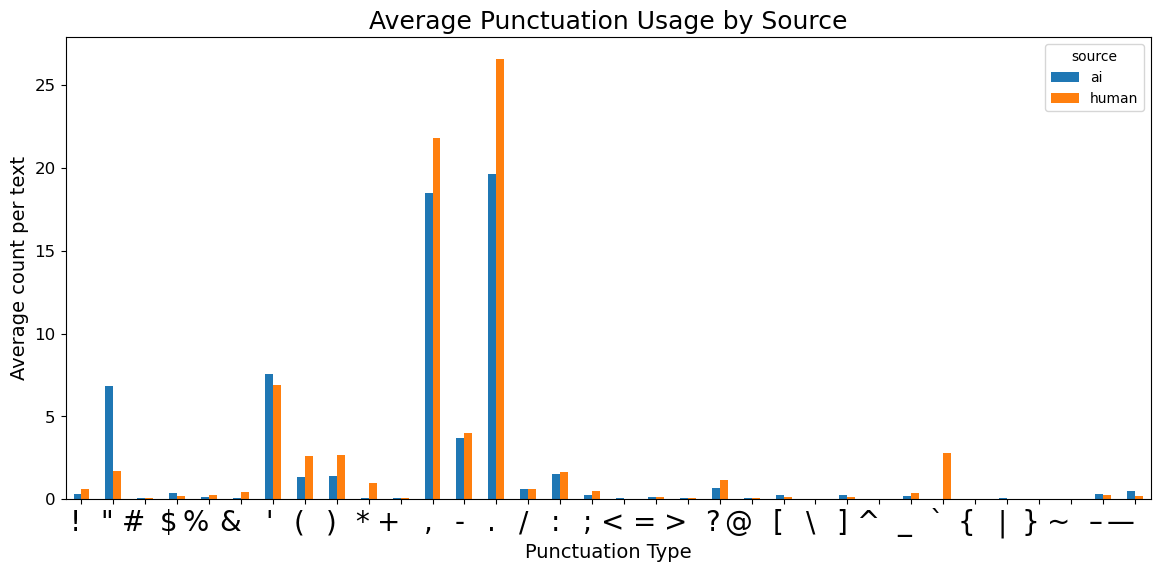

In [69]:
import string
import re
import matplotlib.pyplot as plt

# Define punctuation characters (add em dash and en dash)
punctuations = string.punctuation + "–—"  # en dash (–) and em dash (—)

# Count occurrences of each punctuation in every text
for p in punctuations:
    # Create safe column names by replacing unusual symbols with readable names
    safe_p = p
    if p == "–":
        safe_p = "endash"
    elif p == "—":
        safe_p = "emdash"
    df[f"count_{safe_p}"] = df["text"].str.count(re.escape(p))

# Compute averages by source
punct_avg = (
    df.groupby("source")[
        [col for col in df.columns if col.startswith("count_")]
    ]
    .mean()
    .T
)
punct_avg.index = (
    punct_avg.index.str.replace("count_", "", regex=False)
    .str.replace("endash", "–", regex=False)
    .str.replace("emdash", "—", regex=False)
)

# Plot
punct_avg.plot(kind="bar", figsize=(14, 6))

plt.title("Average Punctuation Usage by Source", fontsize=18)
plt.ylabel("Average count per text", fontsize=14)
plt.xlabel("Punctuation Type", fontsize=14)
plt.xticks(fontsize=20, rotation=0, ha="right")
plt.yticks(fontsize=12)

plt.show()


In [21]:
df["punct_total"] = df["text"].apply(lambda x: len(re.findall(rf"[{re.escape(string.punctuation)}]", str(x))))
avg_punct = df.groupby("source")["punct_total"].mean()
print(avg_punct)

source
ai       64.400750
human    76.546066
Name: punct_total, dtype: float64


In [22]:
df["unique_ratio"] = df["text"].apply(lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0)
df.head()

,source,id,text,text_length,sentence_count,word_count,avg_words_per_sentence,count_!,"count_""",count_#,...,count_],count_^,count__,count_`,count_{,count_|,count_},count_~,punct_total,unique_ratio
0,human,255674,From Trailville\n\nUpper Des Plaines River Can...,4708,38,782,20.578947,0,2,0,...,0,0,0,0,0,0,0,0,121,0.466752
1,human,72144,Coca-Cola Company’s Performance Measurement Es...,2105,20,318,15.900000,0,0,0,...,0,0,0,0,0,0,0,0,41,0.591195
2,human,829552,"I can't stop it, you won't like it, you should...",1000,13,184,14.153846,3,0,0,...,0,0,0,14,0,0,0,0,77,0.728261
3,human,332556,"American Sniper, the Clint Eastwood movie abou...",924,9,161,17.888889,0,0,0,...,0,0,0,0,0,0,0,0,22,0.720497
4,human,999435,eating them.'' His jaw was clenched so tight t...,992,12,185,15.416667,0,0,0,...,0,0,0,6,0,0,0,0,36,0.718919


In [23]:
avg_unique_ratio = df.groupby("source")["unique_ratio"].mean()
print(avg_unique_ratio)

source
ai       0.595630
human    0.650203
Name: unique_ratio, dtype: float64


<Axes: xlabel='source', ylabel='unique_ratio'>

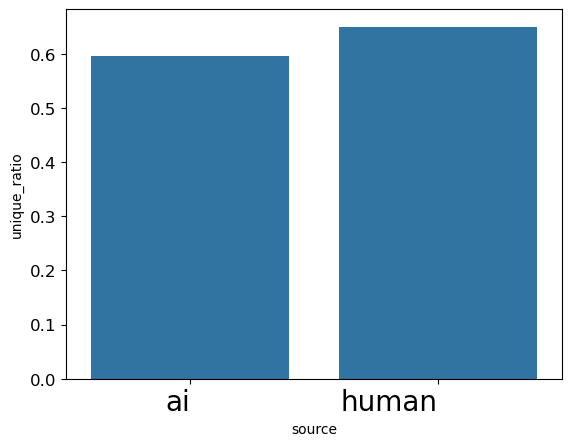

In [24]:
plt.xticks(fontsize=20, rotation=0, ha="right")                # Bigger x-ticks, rotated for readability
plt.yticks(fontsize=12)    
sns.barplot(data=avg_unique_ratio)

# data engineering 2

In [25]:
df.head()

,source,id,text,text_length,sentence_count,word_count,avg_words_per_sentence,count_!,"count_""",count_#,...,count_],count_^,count__,count_`,count_{,count_|,count_},count_~,punct_total,unique_ratio
0,human,255674,From Trailville\n\nUpper Des Plaines River Can...,4708,38,782,20.578947,0,2,0,...,0,0,0,0,0,0,0,0,121,0.466752
1,human,72144,Coca-Cola Company’s Performance Measurement Es...,2105,20,318,15.900000,0,0,0,...,0,0,0,0,0,0,0,0,41,0.591195
2,human,829552,"I can't stop it, you won't like it, you should...",1000,13,184,14.153846,3,0,0,...,0,0,0,14,0,0,0,0,77,0.728261
3,human,332556,"American Sniper, the Clint Eastwood movie abou...",924,9,161,17.888889,0,0,0,...,0,0,0,0,0,0,0,0,22,0.720497
4,human,999435,eating them.'' His jaw was clenched so tight t...,992,12,185,15.416667,0,0,0,...,0,0,0,6,0,0,0,0,36,0.718919


In [26]:
human_df = data[data["source"] == "human"].sample(n=900000, random_state=42)
ai_df    = data[data["source"] == "ai"].sample(n=300000, random_state=42)


df = pd.concat([human_df, ai_df]).reset_index(drop=True)

print(df["source"].value_counts())

source
human    900000
ai       300000
Name: count, dtype: int64


In [27]:
df["text_length"] = df["text"].str.len()

print("text length by source: ",df.groupby("source")["text_length"].mean())

text length by source:  source
ai       2219.645987
human    2467.671636
Name: text_length, dtype: float64


In [28]:
df_small = df.loc[df['text_length']<700]

In [29]:
len(df_small)

159480

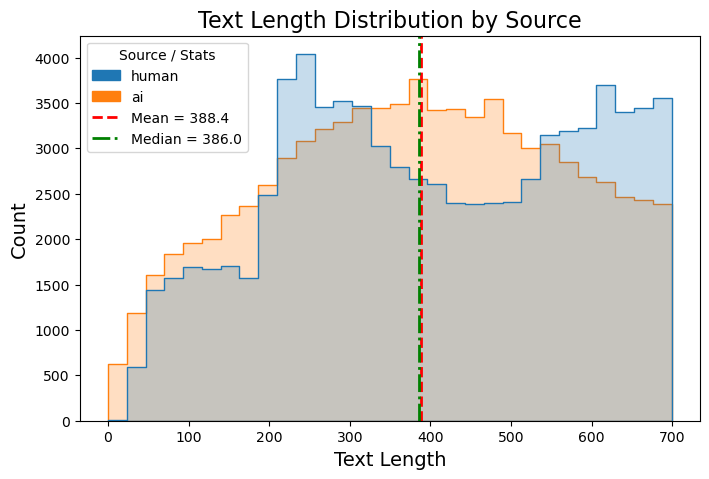

In [30]:

plt.figure(figsize=(8,5))

# Plot histogram
ax = sns.histplot(
    data=df_small,
    x="text_length",
    hue="source",
    bins=30,
    kde=False,
    element="step",   # step outline style
    stat="count"
)

# Calculate stats
mean_val = df_small["text_length"].mean()
median_val = df_small["text_length"].median()

# Add mean/median lines
line_mean = plt.axvline(mean_val, color="red", linestyle="--", linewidth=2,)
line_median = plt.axvline(median_val, color="green", linestyle="-.", linewidth=2)

# --- Build legend manually ---
# Get seaborn's default palette mapping
palette = sns.color_palette(n_colors=df_small["source"].nunique())
sources = df_small["source"].unique()

# Make colored patches for AI/Human
handles = [Patch(facecolor=palette[i], edgecolor=palette[i], label=s) for i, s in enumerate(sources)]

# Add mean/median lines
handles += [line_mean, line_median]
labels = list(sources) + [f"Mean = {mean_val:.1f}", f"Median = {median_val:.1f}"]

plt.legend(handles, labels, title="Source / Stats")

# Titles & labels
plt.title("Text Length Distribution by Source", fontsize=16)
plt.xlabel("Text Length", fontsize=14)
plt.ylabel("Count", fontsize=14)

plt.show()


source
ai       81495
human    77985
Name: count, dtype: int64


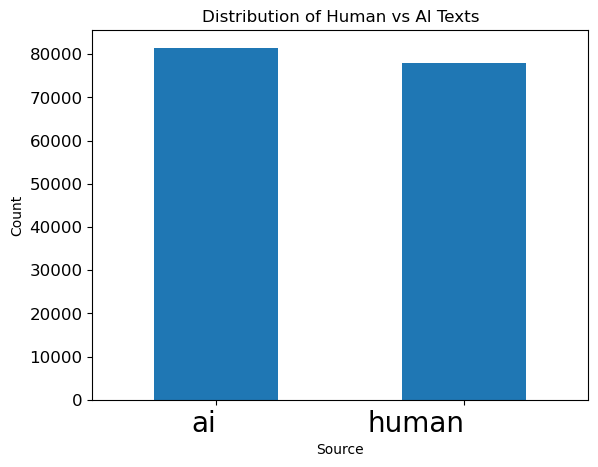

In [31]:
print(df_small["source"].value_counts())
df_small["source"].value_counts().plot(kind="bar")
plt.title("Distribution of Human vs AI Texts")
plt.xlabel("Source")
plt.ylabel("Count")
plt.xticks(fontsize=20, rotation=0, ha="right")                # Bigger x-ticks, rotated for readability
plt.yticks(fontsize=12)    
plt.show()

In [37]:
df_small.to_csv("df_small.csv", index=False)


# creation of small_df

In [54]:
df_small = pd.read_csv("df_small.csv")


# EDA of small DF

In [55]:
df_small = df_small[["source", "text"]]


In [56]:
len(df_small)

159480

source
ai       81495
human    77985
Name: count, dtype: int64


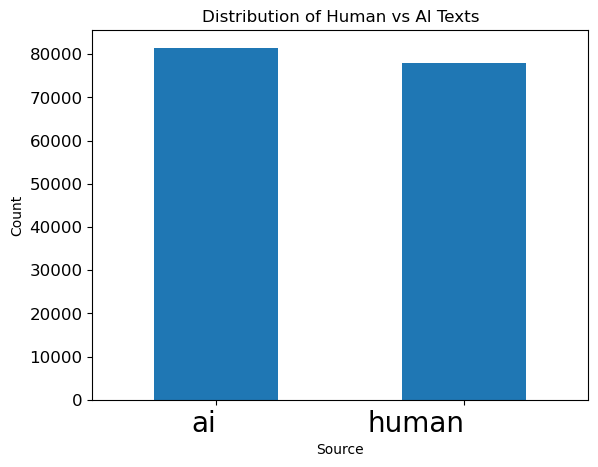

In [57]:
print(df_small["source"].value_counts())
df_small["source"].value_counts().plot(kind="bar")
plt.title("Distribution of Human vs AI Texts")
plt.xlabel("Source")
plt.ylabel("Count")
plt.xticks(fontsize=20, rotation=0, ha="right")                # Bigger x-ticks, rotated for readability
plt.yticks(fontsize=12)    
plt.show()

In [58]:
df_small["text_length"] = df_small["text"].str.len()

print("text length by source: ",df_small.groupby("source")["text_length"].mean())

text length by source:  source
ai       378.560318
human    399.418375
Name: text_length, dtype: float64


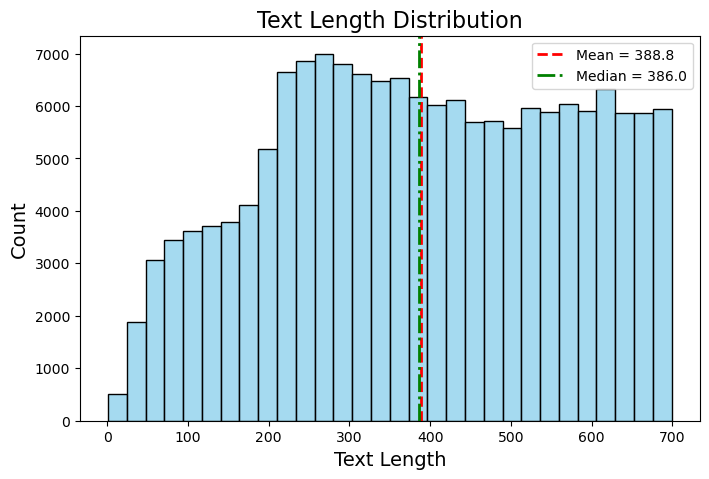

In [59]:
plt.figure(figsize=(8,5))

# Plot a single histogram (no separation by source)
sns.histplot(df_small["text_length"], bins=30, kde=False, color="skyblue")

# Calculate stats
mean_val = df_small["text_length"].mean()
median_val = df_small["text_length"].median()

# Add lines
plt.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_val:.1f}")
plt.axvline(median_val, color="green", linestyle="-.", linewidth=2, label=f"Median = {median_val:.1f}")

# Titles & labels
plt.title("Text Length Distribution", fontsize=16)
plt.xlabel("Text Length", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend()

plt.show()


In [63]:
def count_sentences(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    # Split by ., !, ? followed by space or end of string
    sentences = re.split(r'[.!?]+(?:\s|$)', text.strip())
    # Remove empty strings
    sentences = [s for s in sentences if s]
    return len(sentences)

df_small["sentence_count"] = df_small["text"].apply(count_sentences)

print(df_small.groupby("source")["sentence_count"].mean())

source
ai       4.041990
human    4.625415
Name: sentence_count, dtype: float64


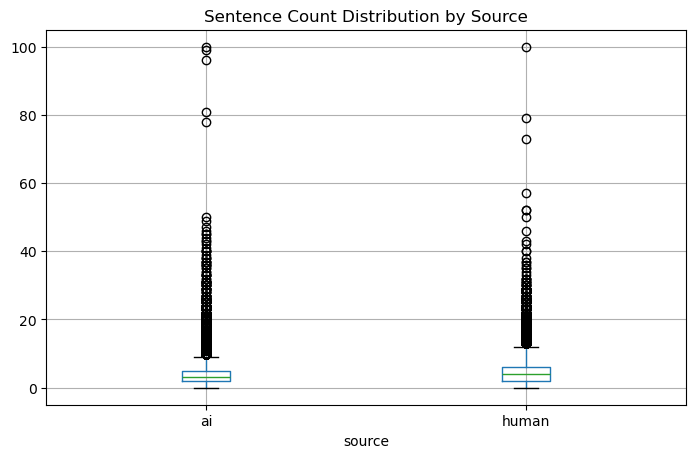

In [64]:
df_small.boxplot(column="sentence_count", by="source", figsize=(8,5))
plt.title("Sentence Count Distribution by Source")
plt.suptitle("")
plt.show()

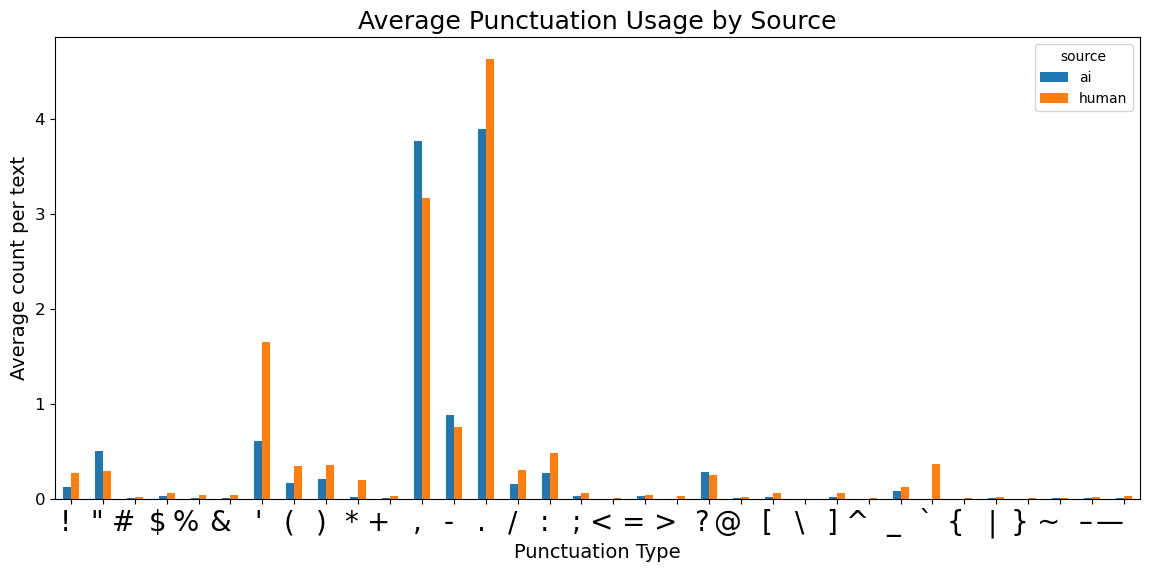

In [68]:
import string
import re
import matplotlib.pyplot as plt

# Define punctuation characters (add em dash and en dash)
punctuations = string.punctuation + "–—"  # en dash (–) and em dash (—)

# Count occurrences of each punctuation in every text
for p in punctuations:
    # Create safe column names by replacing unusual symbols with readable names
    safe_p = p
    if p == "–":
        safe_p = "endash"
    elif p == "—":
        safe_p = "emdash"
    df_small[f"count_{safe_p}"] = df_small["text"].str.count(re.escape(p))

# Compute averages by source
punct_avg = (
    df_small.groupby("source")[
        [col for col in df_small.columns if col.startswith("count_")]
    ]
    .mean()
    .T
)
punct_avg.index = (
    punct_avg.index.str.replace("count_", "", regex=False)
    .str.replace("endash", "–", regex=False)
    .str.replace("emdash", "—", regex=False)
)

# Plot
punct_avg.plot(kind="bar", figsize=(14, 6))

plt.title("Average Punctuation Usage by Source", fontsize=18)
plt.ylabel("Average count per text", fontsize=14)
plt.xlabel("Punctuation Type", fontsize=14)
plt.xticks(fontsize=20, rotation=0, ha="right")
plt.yticks(fontsize=12)

plt.show()


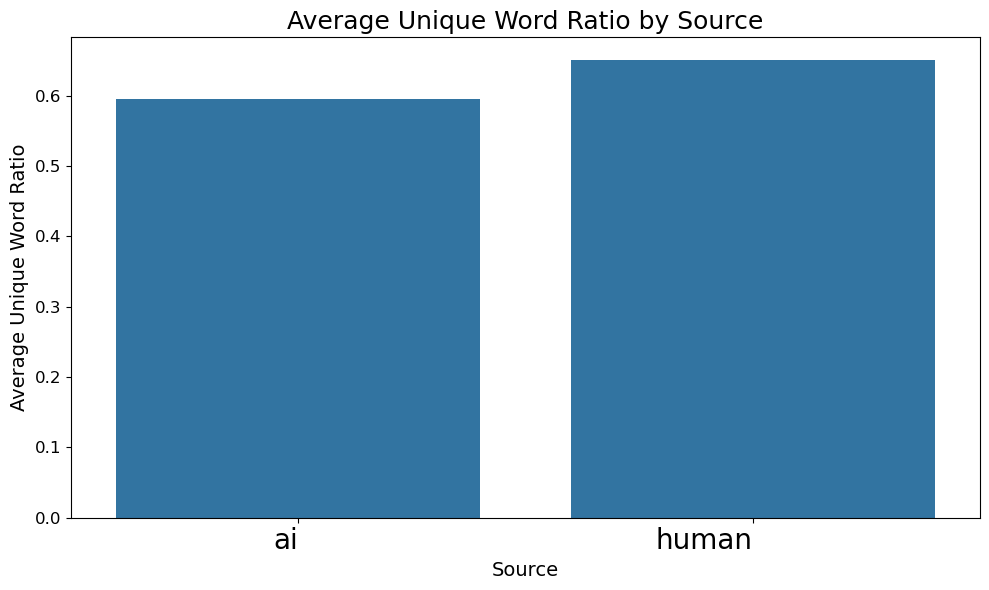

In [67]:

import seaborn as sns
import matplotlib.pyplot as plt

# Convert the Series to a DataFrame and reset the index
avg_unique_ratio = avg_unique_ratio.reset_index()

# Rename columns for clarity
avg_unique_ratio.columns = ["source", "avg_unique_ratio"]

# Plot with seaborn
plt.figure(figsize=(10,6))
sns.barplot(data=avg_unique_ratio, x="source", y="avg_unique_ratio")

plt.title("Average Unique Word Ratio by Source", fontsize=18)
plt.xlabel("Source", fontsize=14)
plt.ylabel("Average Unique Word Ratio", fontsize=14)

plt.xticks(fontsize=20, rotation=0, ha="right")
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [82]:
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger_eng")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


True

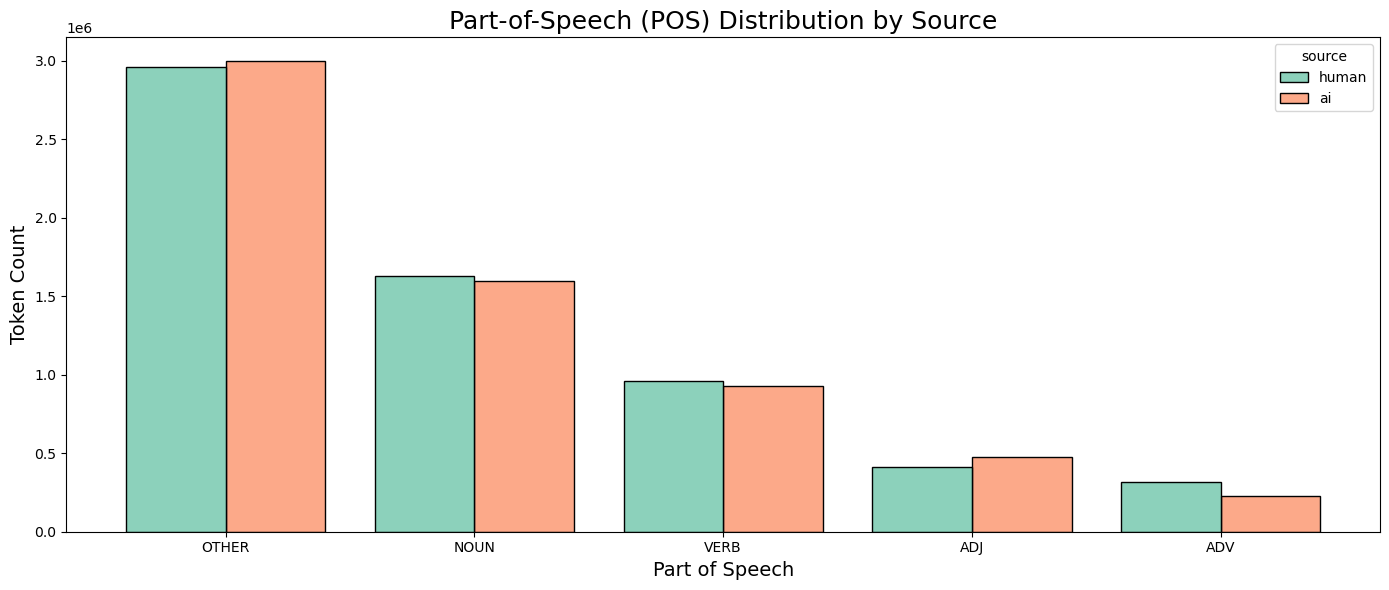

In [84]:


# --- POS Tagging Function ---
def get_pos_groups(text, source):
    if not isinstance(text, str):  # Skip or handle NaN/non-string
        return []
    tokens = word_tokenize(text)
    tags = pos_tag(tokens)
    pos_data = []
    for _, pos in tags:
        if pos.startswith("N"):
            pos_data.append({"source": source, "pos": "NOUN"})
        elif pos.startswith("V"):
            pos_data.append({"source": source, "pos": "VERB"})
        elif pos.startswith("J"):
            pos_data.append({"source": source, "pos": "ADJ"})
        elif pos.startswith("R"):
            pos_data.append({"source": source, "pos": "ADV"})
        else:
            pos_data.append({"source": source, "pos": "OTHER"})
    return pos_data
# --- Apply to your DataFrame ---
pos_records = []
for _, row in df_small.iterrows():
    pos_records.extend(get_pos_groups(row["text"], row["source"]))

pos_df = pd.DataFrame(pos_records)

plt.figure(figsize=(14, 6))
sns.histplot(data=pos_df, x="pos", hue="source", multiple="dodge", shrink=0.8, palette="Set2")
plt.title("Part-of-Speech (POS) Distribution by Source", fontsize=18)
plt.xlabel("Part of Speech", fontsize=14)
plt.ylabel("Token Count", fontsize=14)
plt.tight_layout()
plt.show()
